<center>
    
## Aprendizaje No Supervisado DiploDatos
    Laura Alonso Alemany, Ana Georgina Flesia y Valeria Rulloni
## Agrupamiento con el FIFA 2019 dataset
 
Material basado en notas de Ana Georgina Flesia bajo los términos y condiciones de la licencia [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/), a su vez basado de material de [SilveMel](https://www.kaggle.com/karangadiya/fifa19/downloads/data.csv/comments) y otros.

### Indice de temas
1. [Inicialización del entorno](#1.-Inicialización-del-entorno)
2. [Preparación de los datos](#2.-Preparación-de-los-datos)
3. [Clustering KM](#3.-Clustering-con-Kmeans)
4. [Clustering MS](#4.-Clustering-con-Mean-Shift)
5. [Clustering KM2](#5.-Clustering-con-Kmeans-sin-arqueros)
6. [Clustering MS2](#6.-Clustering-con-Mean-Shift-sin-arqueros)

## 1.-Inicialización-del-entorno

Empezamos cargando algunas herramientas para cargar los datos y manipularlos.

In [6]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows',1000)
import itertools
import warnings
warnings.filterwarnings("ignore")
import io

In [7]:
from plotly.offline import init_notebook_mode, plot,iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)
import matplotlib.pyplot as plt
import plotly.tools as tls#visualization
import plotly.figure_factory as ff#visualization
import seaborn as sns

In [8]:
from sklearn.cluster import KMeans,MeanShift
from sklearn import decomposition

## 2.-Preparación-de-los-datos

Cargamos los datos bajados de la database de [Kaggle](https://www.kaggle.com/karangadiya/fifa19) como 'data.csv'. 

In [9]:
df=pd.read_csv("players_21.csv")

**Preparamos la base para Clustering:**

**Retiramos jugadores con bajo Desempeño global ("Overall")**

**y consideramos Variables de desempeño por habilidad (skills_ratings)**

In [10]:
n=10000
df_n=df.loc[:n] #los primeros n
df_n=df_n[(df_n['overall']>70)] # mejores jugadores

skills_ratings = ['pace', 'shooting',
       'passing', 'dribbling', 'defending', 'physic', 'gk_diving',
       'gk_handling', 'gk_kicking', 'gk_reflexes', 'gk_speed',
       'gk_positioning', 'attacking_crossing', 'attacking_finishing',
       'attacking_heading_accuracy', 'attacking_short_passing',
       'attacking_volleys', 'skill_dribbling', 'skill_curve',
       'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control',
       'movement_acceleration', 'movement_sprint_speed', 'movement_agility',
       'movement_reactions', 'movement_balance', 'power_shot_power',
       'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots',
       'mentality_aggression', 'mentality_interceptions',
       'mentality_positioning', 'mentality_vision', 'mentality_penalties',
       'mentality_composure', 'defending_marking', 'defending_standing_tackle',
       'defending_sliding_tackle', 'goalkeeping_diving',
       'goalkeeping_handling', 'goalkeeping_kicking',
       'goalkeeping_positioning', 'goalkeeping_reflexes']

print(len(skills_ratings), 'variables numéricas: skills/habilidades')

df_skills=df_n[skills_ratings]

46 variables numéricas: skills/habilidades


# 3.-Clustering-con-Kmeans

ES necesario definirle la cantidad de grupos/clusters (n_clusters), es un hiperparámetro del algoritmo. 


In [11]:
df_skills.fillna(0,inplace=True)

Text(0.5, 1.0, 'Inertia of k-Means versus number of clusters')

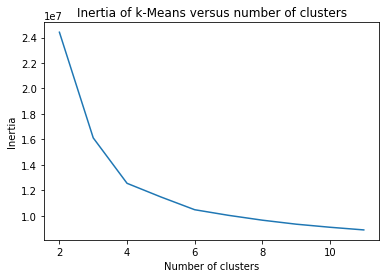

In [12]:
#Prueba: para elegir el hiperparámetro n_clusters, variando de 2 a 11 clusters
scores = [KMeans(n_clusters=i).fit(df_skills).inertia_ for i in range(2,12)]

plt.plot(np.arange(2, 12), scores)
plt.xlabel('Number of clusters')
plt.ylabel("Inertia")
plt.title("Inertia of k-Means versus number of clusters")

In [27]:
# Número de clusters buscado
n_clust = 4

km = KMeans(n_clusters=n_clust)
km.fit(df_skills) #utiliza todas las habilidades: 34 dimensiones

# Recuperacion de etiquetas
clusters = km.labels_
print('Suma de los cuadrados de las distancias al cluster=Inertia= ', km.inertia_)

Suma de los cuadrados de las distancias al cluster=Inertia=  12560494.1605865


In [15]:
len(clusters)

4512

**Elección de la cantidad de grupos/clusters**

Una forma de seleccionar la cantidad más adecuada de clusters es probar varias cantidades y usar el criterio del codo: "elbow method", utilizando una medida de ajuste que puede ser Inertia.

**Graficamos el resultado de agrupar a los jugadores usando kmedias con la cantidad de clases elegida: Visualizamos de a dos variables por vez**

In [16]:
bool_crack=df_n["overall"] > 85
bool_no_crack=df_n["overall"]<86

#Eligo dos números entre 0 y  de n_skills-1
skill_1=skills_ratings[15]
skill_2=skills_ratings[26]

In [25]:
df.head()

,sofifa_id,player_url,short_name,long_name,age,dob,height_cm,weight_kg,nationality,club_name,league_name,league_rank,overall,potential,value_eur,wage_eur,player_positions,preferred_foot,international_reputation,weak_foot,skill_moves,work_rate,body_type,real_face,release_clause_eur,player_tags,team_position,team_jersey_number,loaned_from,joined,contract_valid_until,nation_position,nation_jersey_number,pace,shooting,passing,dribbling,defending,physic,gk_diving,gk_handling,gk_kicking,gk_reflexes,gk_speed,gk_positioning,player_traits,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,...,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,ls,st,rs,lw,lf,cf,rf,rw,lam,cam,ram,lm,lcm,cm,rcm,rm,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb
0,158023,https://sofifa.com/player/158023/lionel-messi/...,L. Messi,Lionel Andrés Messi Cuccittini,33,1987-06-24,170,72,Argentina,FC Barcelona,Spain Primera Division,1.0,93,93,67500000,560000,"RW, ST, CF",Left,5,4,4,Medium/Low,Messi,Yes,138400000.0,"#Dribbler, #Distance Shooter, #FK Specialist, ...",CAM,10.0,NaN,2004-07-01,2021.0,RW,10.0,85.0,92.0,91.0,95.0,38.0,65.0,NaN,NaN,NaN,NaN,NaN,NaN,"Finesse Shot, Long Shot Taker (AI), Speed Drib...",85,95,70,91,...,91,80,91,94,95,86,68,72,69,94,44,40,93,95,75,96,NaN,35,24,6,11,15,14,8,89+3,89+3,89+3,92+0,93+0,93+0,93+0,92+0,93+0,93+0,93+0,91+2,87+3,87+3,87+3,91+2,66+3,65+3,65+3,65+3,66+3,62+3,52+3,52+3,52+3,62+3
1,20801,https://sofifa.com/player/20801/c-ronaldo-dos-...,Cristiano Ronaldo,Cristiano Ronaldo dos Santos Aveiro,35,1985-02-05,187,83,Portugal,Juventus,Italian Serie A,1.0,92,92,46000000,220000,"ST, LW",Right,5,4,5,High/Low,C. Ronaldo,Yes,75900000.0,"#Aerial Threat, #Dribbler, #Distance Shooter, ...",LS,7.0,NaN,2018-07-10,2022.0,LS,7.0,89.0,93.0,81.0,89.0,35.0,77.0,NaN,NaN,NaN,NaN,NaN,NaN,"Power Free-Kick, Flair, Long Shot Taker (AI), ...",84,95,90,82,...,87,91,87,95,71,94,95,84,78,93,63,29,95,82,84,95,NaN,32,24,7,11,15,14,11,91+1,91+1,91+1,89+0,91+0,91+0,91+0,89+0,88+3,88+3,88+3,88+3,81+3,81+3,81+3,88+3,65+3,61+3,61+3,61+3,65+3,61+3,54+3,54+3,54+3,61+3
2,200389,https://sofifa.com/player/200389/jan-oblak/210002,J. Oblak,Jan Oblak,27,1993-01-07,188,87,Slovenia,Atlético Madrid,Spain Primera Division,1.0,91,93,75000000,125000,GK,Right,3,3,1,Medium/Medium,PLAYER_BODY_TYPE_259,Yes,159400000.0,NaN,GK,13.0,NaN,2014-07-16,2023.0,GK,1.0,NaN,NaN,NaN,NaN,NaN,NaN,87.0,92.0,78.0,90.0,52.0,90.0,"GK Long Throw, Comes For Crosses",13,11,15,43,...,43,60,67,88,49,59,78,41,78,12,34,19,11,65,11,68,NaN,12,18,87,92,78,90,90,33+3,33+3,33+3,32+0,35+0,35+0,35+0,32+0,38+3,38+3,38+3,35+3,38+3,38+3,38+3,35+3,32+3,36+3,36+3,36+3,32+3,32+3,33+3,33+3,33+3,32+3
3,188545,https://sofifa.com/player/188545/robert-lewand...,R. Lewandowski,Robert Lewandowski,31,1988-08-21,184,80,Poland,FC Bayern München,German 1. Bundesliga,1.0,91,91,80000000,240000,ST,Right,4,4,4,High/Medium,PLAYER_BODY_TYPE_276,Yes,132000000.0,"#Distance Shooter, #Clinical Finisher",ST,9.0,NaN,2014-07-01,2023.0,NaN,NaN,78.0,91.0,78.0,85.0,43.0,82.0,NaN,NaN,NaN,NaN,NaN,NaN,"Solid Player, Finesse Shot, Outside Foot Shot,...",71,94,85,84,...,77,78,77,93,82,89,84,76,86,85,81,49,94,79,88,88,NaN,42,19,15,6,12,8,10,89+2,89+2,89+2,85+0,87+0,87+0,87+0,85+0,85+3,85+3,85+3,83+3,79+3,79+3,79+3,83+3,64+3,65+3,65+3,65+3,64+3,61+3,60+3,60+3,60+3,61+3
4,190871,https://sofifa.com/player/190871/neymar-da-sil...,Neymar Jr,Neymar da Silva Santos Júnior,28,1992-02-05,175,68,Brazil,Paris Saint-Germain,French Ligue 1,1.0,91,91,90000000,270000,"LW, CAM",Right,5,5,5,High/Medium,Neymar,Yes,166500000.0,"

In [28]:
df_skills["cluster"] = clusters

In [31]:
mediocampistas = ["CAM","CM","RM","LM", "LCM", "RCM"]
delanteros = ["LW","RW","CF","ST", "LAM", "LF", "RF", "LS", "RS", "RAM", "SUB"]
defensores = ["LWB", "LB", "CB", "RB", "RWB", "LCB", "RCB","RDM","LDM","CDM", "RES"]

In [32]:
df_skill_copy = df_skills.copy()

In [37]:
df.columns

Index(['sofifa_id', 'player_url', 'short_name', 'long_name', 'age', 'dob',
       'height_cm', 'weight_kg', 'nationality', 'club_name',
       ...
       'lwb', 'ldm', 'cdm', 'rdm', 'rwb', 'lb', 'lcb', 'cb', 'rcb', 'rb'],
      dtype='object', length=106)

In [38]:
def positions(row):
    if row["team_position"] in mediocampistas:
        return "mediocampista"
    elif row["team_position"] in delanteros:
        return "delanteros"
    elif row["team_position"] in defensores:
        return "defensores"
    else:
        return "arquero"
df_skill_copy["position"] = df.apply(positions, axis=1)

In [43]:
df_skill_copy

,pace,shooting,passing,dribbling,defending,physic,gk_diving,gk_handling,gk_kicking,gk_reflexes,gk_speed,gk_positioning,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,cluster,position
0,85.0,92.0,91.0,95.0,38.0,65.0,0.0,0.0,0.0,0.0,0.0,0.0,85,95,70,91,88,96,93,94,91,96,91,80,91,94,95,86,68,72,69,94,44,40,93,95,75,96,0.0,35,24,6,11,15,14,8,2,mediocampista
1,89.0,93.0,81.0,89.0,35.0,77.0,0.0,0.0,0.0,0.0,0.0,0.0,84,95,90,82,86,88,81,76,77,92,87,91,87,95,71,94,95,84,78,93,63,29,95,82,84,95,0.0,32,24,7,11,15,14,11,2,delanteros
2,0.0,0.0,0.0,0.0,0.0,0.0,87.0,92.0,78.0,90.0,52.0,90.0,13,11,15,43,13,12,13,14,40,30,43,60,67,88,49,59,78,41,78,12,34,19,11,65,11,68,0.0,12,18,87,92,78,90,90,1,arquero
3,78.0,91.0,78.0,85.0,43.0,82.0,0.0,0.0,0.0,0.0,0.0,0.0,71,94,85,84,89,85,79,85,70,88,77,78,77,93,82,89,84,76,86,85,81,49,94,79,88,88,0.0,42,19,15,6,12,8,10,2,delanteros
4,91.0,85.0,86.0,94.0,36.0,59.0,0.0,0.0,0.0,0.0,0.0,0.0,85,87,62,87,87,95,88,89,81,95,94,89,96,91,83,80,62,81,50,84,51,36,87,90,92,93,0.0,30,29,9,9,15,15,11,2,delanteros
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4507,86.0,54.0,69.0,71.0,57.0,52.0,0.0,0.0,0.0,0.0,0.0,0.0,76,54,54,67,55,70,74,65,64,68,87,85,77,66,85,58,52,76,42,48,48,60,65,69,41,66,0.0,57,62,13,10,14,14,14,3,mediocampista
4508,82.0,68.0,64.0,73.0,32.0,58.0,0.0,0.0,0.0,0.0,0.0,0.0,68,68,48,69,61,73,53,42,57,71,83,82,81,64,78,78,56,69,63,58,33,27,69,66,66,67,0.0,35,34,8,8,10,14,10,2,delanteros
4509,76.0,61.0,71.0,75.0,62.0,83.0,0.0,0.0,0.0,0.0,0.0,0.0,67,55,51,73,51,73,81,63,71,75,79,73,80,71,83,75,69,88,81,61,83,63,59,71,61,81,0.0,69,59,12,9,10,13,9,3,mediocampista
4510,0.0,0.0,0.0,0.0,0.0,0.0,71.0,72.0,71.0,67.0,21.0,71.0,14,6,13,21,9,9,14,11,21,18,28,16,21,69,26,53,33,24,60,6,28,7,8,51,19,29,0.0,14,11,71,72,71,71,67,1,arquero


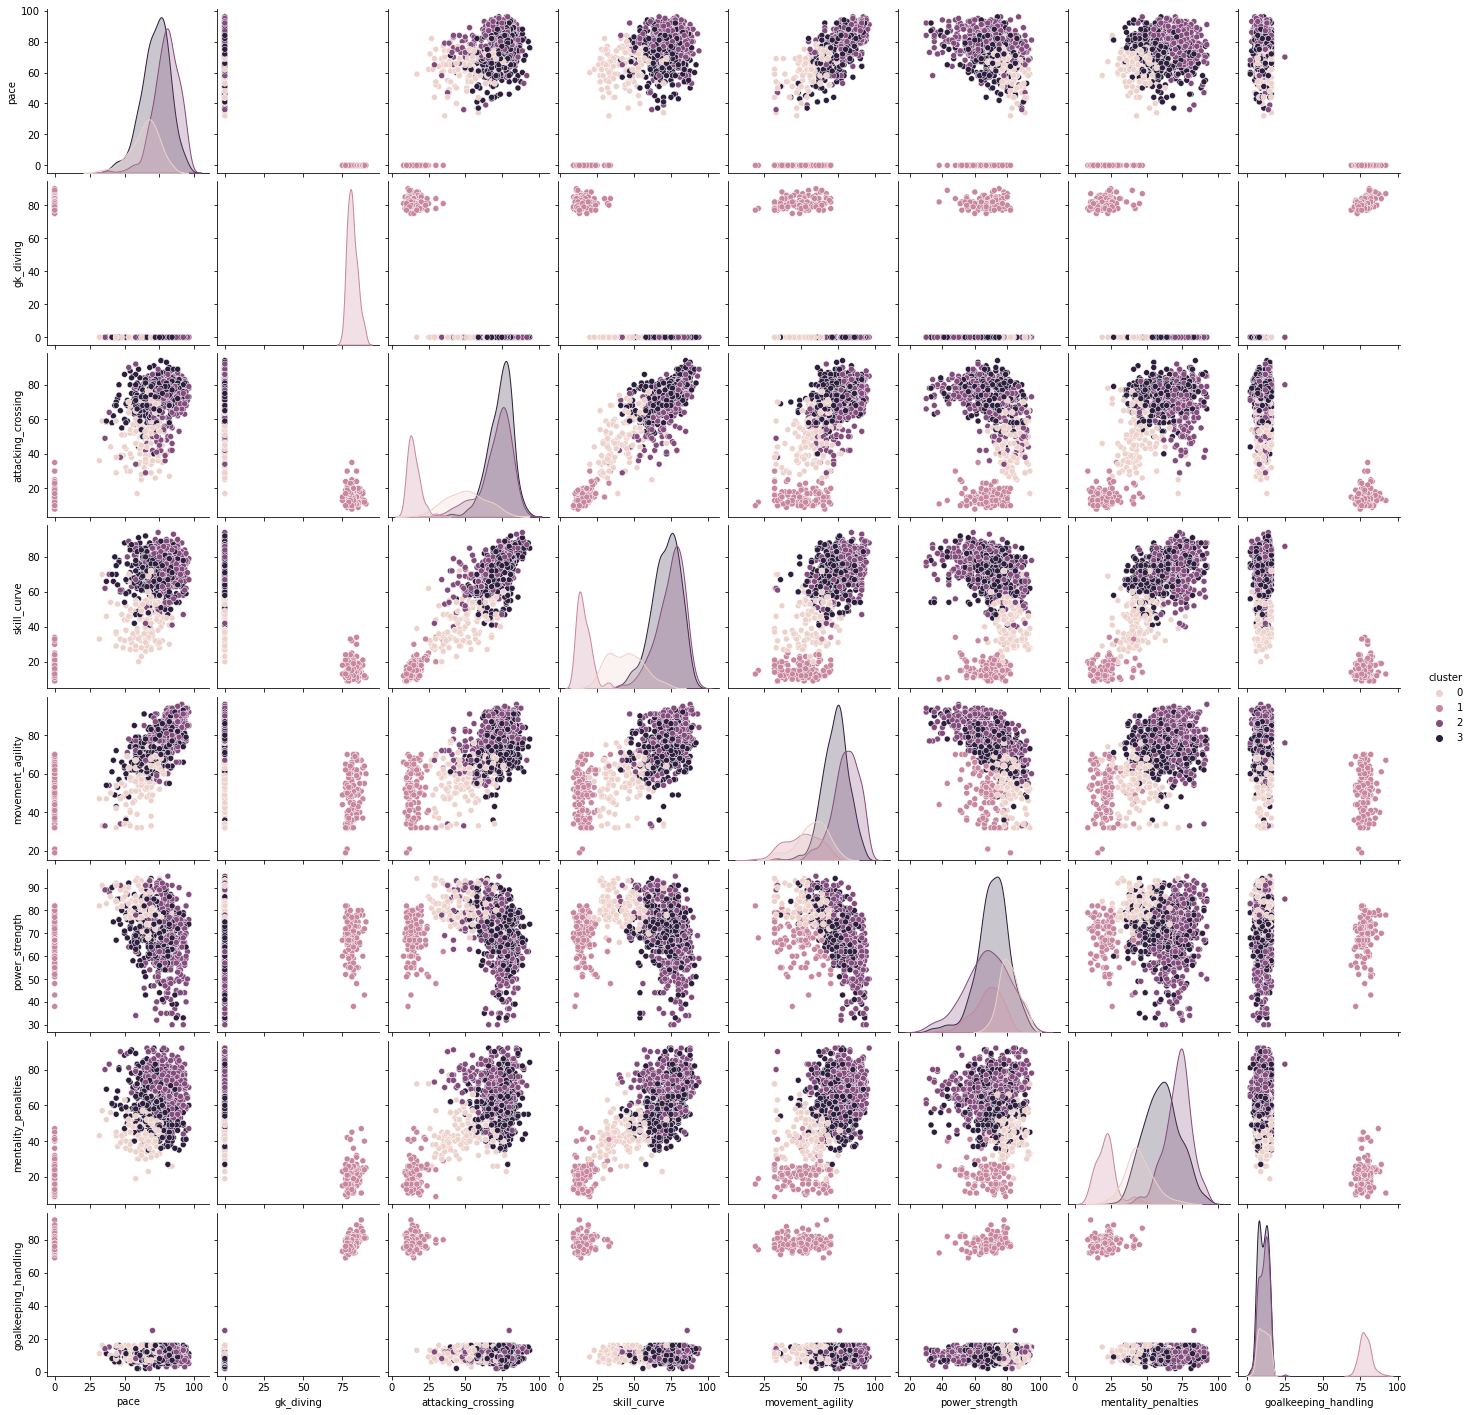

In [30]:
sns.pairplot(
    df_skills[:1000],
    x_vars=skills_ratings[0:46:6],
    y_vars=skills_ratings[0:46:6],
    hue="cluster"
)

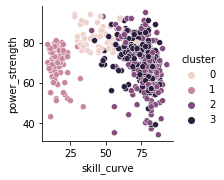

In [48]:
sns.pairplot(
    df_skills[:500],
    x_vars="skill_curve",
    y_vars="power_strength",
    hue="cluster"
)

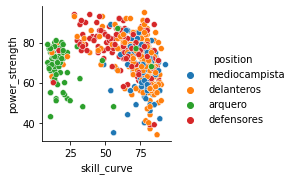

In [49]:
sns.pairplot(
    df_skill_copy[:500],
    x_vars="skill_curve",
    y_vars="power_strength",
    hue="position"
)

Comparamos lo realizado por kmeans y lo agrupado manualmente
Se ve que a los arqueros los agrupa de manera correcta, existe una interconexión entre las demás posiciones.

**EVALUACIÓN**

**EJERCICIO: Análisis exploratorio de los clusters, usando las clases asignadas por kmeans** 
- Cantidad de observaciones por Cluster
- Análisis descriptivo separando por Cluster
- Tabla de contingencia alguna categórica vs clusters
- Silohuette?


# Cantidad de observaciones

In [51]:
df_skill_copy["position"].value_counts()

delanteros       1972
defensores       1412
mediocampista     746
arquero           382
Name: position, dtype: int64

In [50]:
df_skills["cluster"].value_counts()

3    1660
2    1478
0     930
1     444
Name: cluster, dtype: int64

# Análisis descriptivo

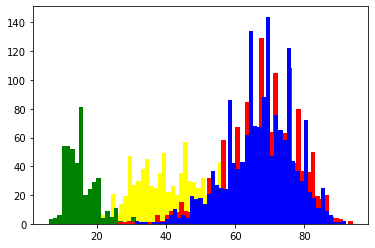

In [55]:
df_0 = df_skills[ df_skills['cluster']==0]
df_1 = df_skills[ df_skills['cluster']==1]
df_2 = df_skills[ df_skills['cluster']==2]
df_3 = df_skills[ df_skills['cluster']==3]

plt.hist(df_0['skill_curve'], color='yellow', bins=50)
plt.hist(df_1['skill_curve'], color='green', bins=50)
plt.hist(df_2['skill_curve'], color='red', bins=50)
plt.hist(df_3['skill_curve'], color='blue', bins=50)
plt.show()

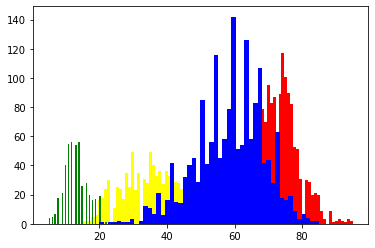

In [56]:
# delanteros
df_0 = df_skills[ df_skills['cluster']==0]
df_1 = df_skills[ df_skills['cluster']==1]
df_2 = df_skills[ df_skills['cluster']==2]
df_3 = df_skills[ df_skills['cluster']==3]

plt.hist(df_0['attacking_finishing'], color='yellow', bins=50)
plt.hist(df_1['attacking_finishing'], color='green', bins=50)
plt.hist(df_2['attacking_finishing'], color='red', bins=50)
plt.hist(df_3['attacking_finishing'], color='blue', bins=50)
plt.show()

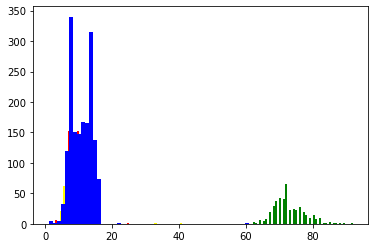

In [57]:
# arqueros
df_0 = df_skills[ df_skills['cluster']==0]
df_1 = df_skills[ df_skills['cluster']==1]
df_2 = df_skills[ df_skills['cluster']==2]
df_3 = df_skills[ df_skills['cluster']==3]

plt.hist(df_0['goalkeeping_handling'], color='yellow', bins=50)
plt.hist(df_1['goalkeeping_handling'], color='green', bins=50)
plt.hist(df_2['goalkeeping_handling'], color='red', bins=50)
plt.hist(df_3['goalkeeping_handling'], color='blue', bins=50)
plt.show()

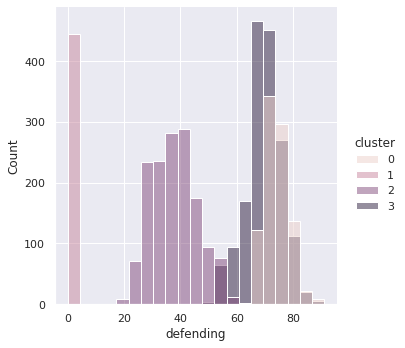

In [79]:
sns.displot(df_skills,x="defending",hue="cluster")

In [80]:
def distribution_per_type(df, col_name="", bins=20):
    plt.title(f"{col_name.capitalize()} Distribution")
    sns.distplot(df[df["cluster"] == 0][col_name],label="cluster-0", bins=bins)
    sns.distplot(df[df["cluster"] == 1][col_name],label="cluster-1", bins=bins)
    sns.distplot(df[df["cluster"] == 2][col_name],label="cluster-2", bins=bins)
    sns.distplot(df[df["cluster"] == 3][col_name],label="cluster-3", bins=bins)
    plt.legend()

In [88]:
def exploratory_plots(df, col_name=""):
    plt.subplot(3, 1, 1)
    distribution_per_type(df, col_name)
    plt.subplot(3, 1, 2)
    plt.title(f"{col_name.capitalize()} Boxplot")
    sns.boxplot(x="cluster", y=col_name, data=df)
    sns.set(rc={'figure.figsize':(20,15)})
    
    #plt.tight_layout()

In [85]:
df_skills["defending"].describe()

count    4512.000000
mean       53.068484
std        24.097258
min         0.000000
25%        36.000000
50%        64.000000
75%        72.000000
max        91.000000
Name: defending, dtype: float64

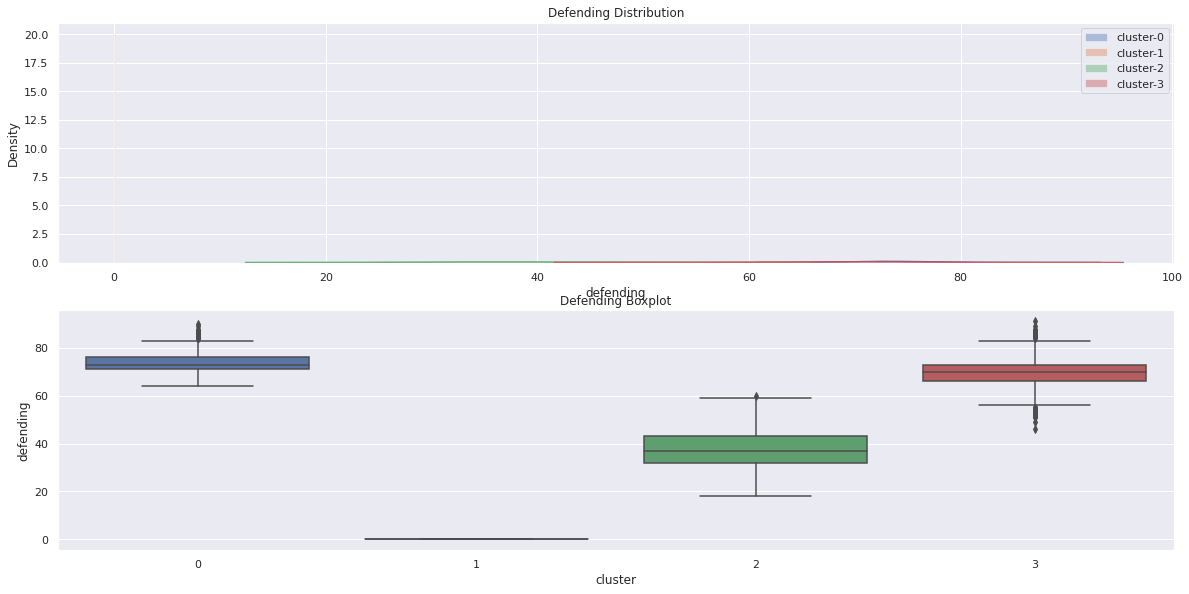

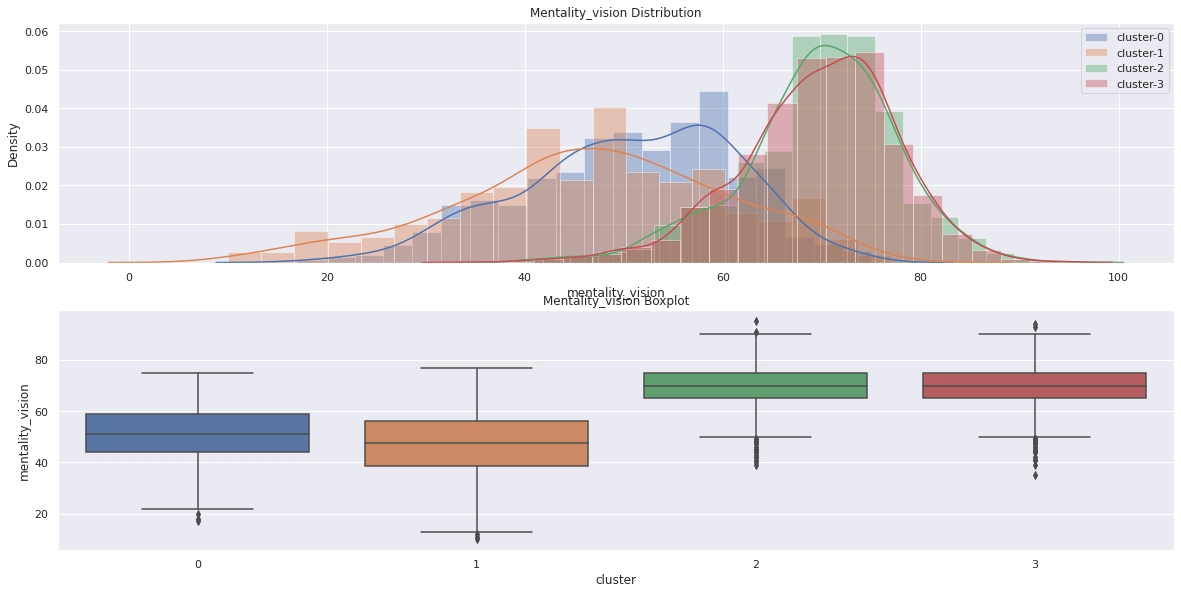

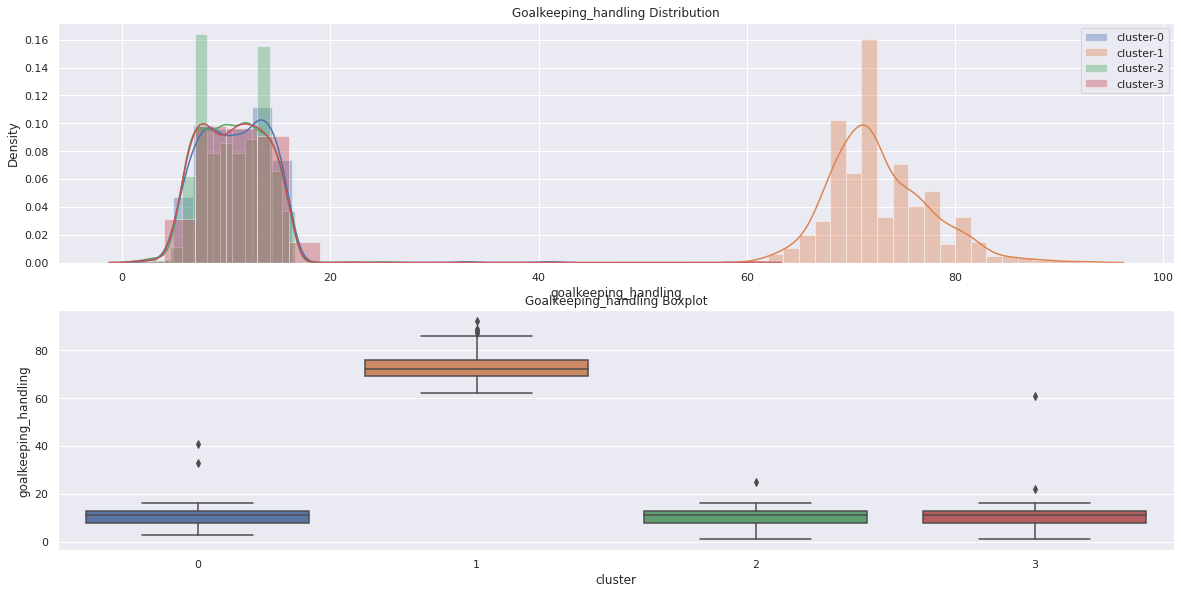

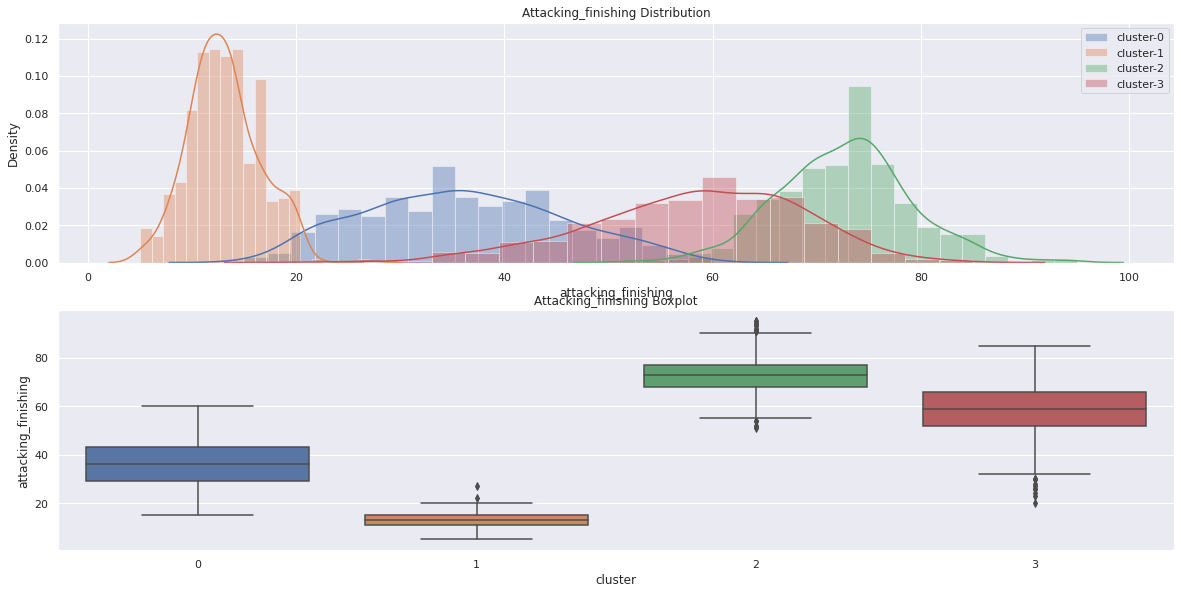

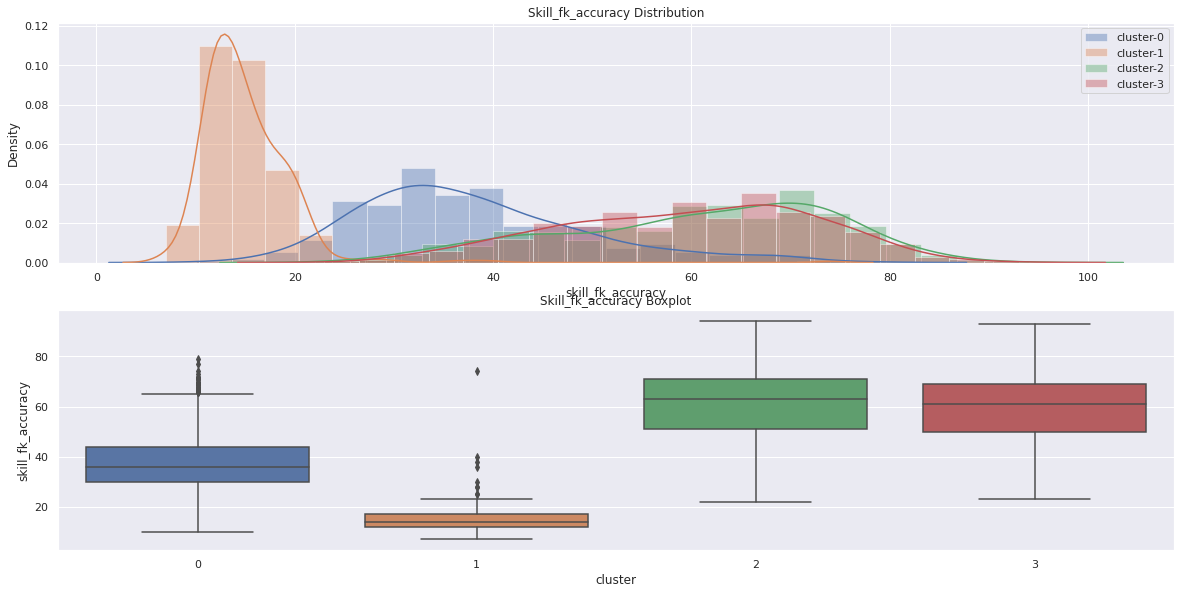

In [89]:
for skill in ["defending","mentality_vision","goalkeeping_handling","attacking_finishing", "skill_fk_accuracy"]:
    plt.figure()
    exploratory_plots(df_skills, skill)

# silhouette score

In [92]:
from sklearn.metrics import silhouette_score

In [93]:
score = silhouette_score(df_skills, km.labels_, metric='euclidean')
print('Silhouetter Score: %.3f' % score)

Silhouetter Score: 0.324


In [95]:
!pip install yellowbrick

     |████████████████████████████████| 271 kB 801 kB/s eta 0:00:01
     |████████████████████████████████| 14.9 MB 1.0 MB/s eta 0:00:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.20.3
    Uninstalling numpy-1.20.3:
      Successfully uninstalled numpy-1.20.3


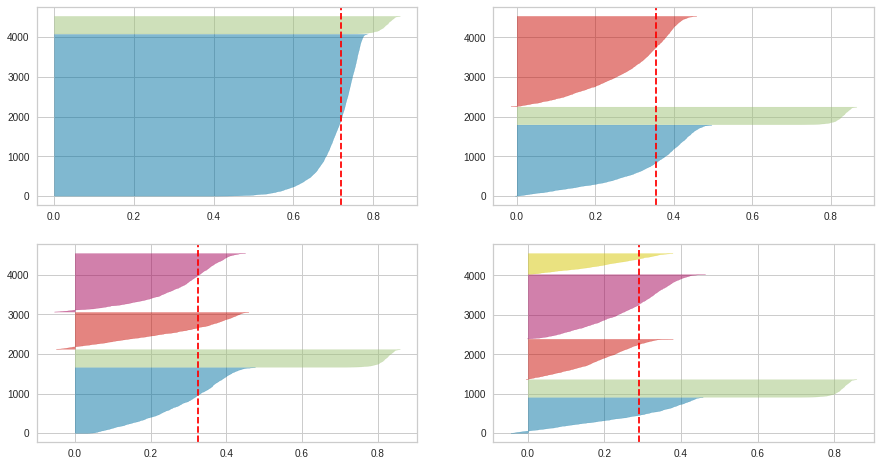

In [97]:
from yellowbrick.cluster import SilhouetteVisualizer

fig, ax = plt.subplots(2, 2, figsize=(15,8))
for i in [2, 3, 4, 5]:
    '''
    Create KMeans instance for different number of clusters
    '''
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(i, 2)
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(df_skills)

In [107]:
df["work_rate"]

0           Medium/Low
1             High/Low
2        Medium/Medium
3          High/Medium
4          High/Medium
             ...      
18939    Medium/Medium
18940          Low/Low
18941       Low/Medium
18942          Low/Low
18943          Low/Low
Name: work_rate, Length: 18944, dtype: object

In [106]:
df.describe(include=[object])

,player_url,short_name,long_name,dob,nationality,club_name,league_name,player_positions,preferred_foot,work_rate,body_type,real_face,player_tags,team_position,loaned_from,joined,nation_position,player_traits,ls,st,rs,lw,lf,cf,rf,rw,lam,cam,ram,lm,lcm,cm,rcm,rm,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb
count,18944,18944,18944,18944,18944,18719,18719,18944,18944,18944,18944,18944,1408,18719,758,17961,1127,8315,18944,18944,18944,18944,18944,18944,18944,18944,18944,18944,18944,18944,18944,18944,18944,18944,18944,18944,18944,18944,18944,18944,18944,18944,18944,18944
unique,18944,17884,18896,6236,162,681,52,611,2,9,118,2,75,29,278,1822,26,915,206,206,206,104,103,103,103,104,233,233,233,223,213,213,213,223,201,219,219,219,201,196,222,222,222,196
top,https://sofifa.com/player/158023/lionel-messi/...,J. Rodríguez,Liam Kelly,1992-02-29,England,FC Barcelona,English League Championship,CB,Right,Medium/Medium,Normal,No,#Strength,SUB,Chelsea,2019-07-01,SUB,Speed Dribbler (AI),61+2,61+2,61+2,64+0,62+0,62+0,62+0,64+0,62+2,62+2,62+2,61+2,61+2,61+2,61+2,61+2,59+2,61+2,61+2,61+2,59+2,60+2,61+2,61+2,61+2,60+2
freq,1,13,3,128,1685,33,709,2437,14448,9980,11264,16746,459,8065,12,1315,588,627,708,708,708,749,771,771,771,749,713,713,713,745,776,776,776,745,717,614,614,614,717,680,528,528,528,680


# tabla de contingencia

In [108]:
pd.crosstab(df['work_rate'], df_skills['cluster']) 

cluster,0,1,2,3
work_rate,,,,
High/High,32,0,145,290
High/Low,1,0,200,26
High/Medium,96,0,540,524
Low/High,87,0,0,22
Low/Low,1,0,3,1
Low/Medium,66,0,2,10
Medium/High,289,0,26,251
Medium/Low,0,0,187,11
Medium/Medium,358,444,375,525


In [104]:
pd.crosstab(df['team_position'], df_skills['cluster']) 

cluster,0,1,2,3
team_position,,,,
CAM,0,0,87,41
CB,31,0,0,10
CDM,14,0,1,57
CF,0,0,6,2
CM,0,0,1,18
GK,0,293,0,0
LAM,0,0,10,2
LB,31,0,0,153
LCB,190,0,0,23


# 4.-Clustering-Mean-Shift 

- NO es necesario definirle la cantidad de grupos/clusters
- NO es escalable, computacionalmente es muy pesado. Cada dato tienen un proceso iterativo en donde en cada iteración considera los vecinos a menos de un radio de distancia.
- Hipeparámetros: radio/bandwith (de cobertura para cálculo de media). (Probar con varios)

In [9]:
ms = MeanShift(bandwidth=2, bin_seeding=True)

ms.fit(df_skills)

clusters2 = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(clusters2)
n_clusters_ = len(labels_unique)

print("Cantidad de clusters encontrados por Mean Shift : %d" % n_clusters_)

Cantidad de clusters encontrados por Mean Shift : 3


Graficamos los resultados:

In [10]:
bool_crack=df_n["Overall"] > 85
bool_no_crack=df_n["Overall"]<86

#Eligo dos números entre 0 y  de n_skills-1
skill_1=skills_ratings[5]
skill_2=skills_ratings[14]

In [27]:
data=[]
MeanShift_clusters = go.Scatter(x=df_skills[skill_1], y=df_skills[skill_2],
                           mode='markers',
                        text=df_n.loc[:,'Name'],
                           marker=dict(
                                size=5,
                                color = clusters2.astype(np.float), #set color equal to a variable
                                colorscale='Portland',
                                showscale=False)
                           )

crack =go.Scatter(x=df_skills.loc[bool_crack,skill_1], y=df_skills.loc[bool_crack,skill_2],name='Top players',
                      text=df_n.loc[bool_crack,'Name'],
                      textfont=dict(family='sans serif',size=10,color='black'),
                      opacity=0.9,mode='text')

data=[MeanShift_clusters,crack]

layout = go.Layout(title="Mean Shift",titlefont=dict(size=20),
                xaxis=dict(title=skill_1),
                yaxis=dict(title=skill_2),
                autosize=False, width=1000,height=650)

fig = go.Figure(data=data, layout=layout)

In [28]:
#En Colab
fig.show(renderer="colab")

In [23]:
df_clusters['MeanShift'] = ms.labels_ #clusters2
print('Kmeans encontró: ', max(km.labels_)+1, 'clusters, nosotros lo forzamos')
print('Mean shift encontró ', max(ms.labels_)+1, 'clusters, según los hiperparámetros elegidos')

Kmeans encontró:  5 clusters, nosotros lo forzamos
Mean shift encontró  3 clusters, según los hiperparámetros elegidos


**EVALUACIÓN**

**EJERCICIO EN GRUPO: Análisis exploratorio de los clusters, usando las clases asignadas por MeanShift** 

In [ ]:
#Cantidad de observaciones por Cluster
#Análisis descriptivo separando por Cluster
#Tabla de contingencia alguna categórica vs clusters
#Silohuette?


**Pregunta: normalizamos/estandarizamos la base?**

**Ahora vemos que agrupamientos se pueden hacer excluyendo los arqueros**

# 5.-Clustering-con-Kmeans-sin-arqueros

In [11]:
n=10000
df_n=df.loc[:n]
df_n=df_n[(df_n["Position"]!='GK')&(df_n['Overall']>69)]

skills_ratings = ['Crossing', 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling', 'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration', 'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower', 'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression', 'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure', 'Marking', 'StandingTackle', 'SlidingTackle']

df_skills=df_n[skills_ratings]


In [12]:
# Número de clusters buscado
n_clust = 5

km = KMeans(n_clusters=n_clust)
km.fit(df_skills)

# Recuperacion de etiquetas
clusters = km.labels_

In [13]:
#data=[]
bool_crack=df_n["Overall"] > 85
bool_no_crack=df_n["Overall"]<86

#Eligo dos números entre 0 y  de n_skills-1
skill_1=skills_ratings[5]
skill_2=skills_ratings[15]

In [15]:
kmean_clusters = go.Scatter(x=df_skills[skill_1], y=df_skills[skill_2],
                           mode='markers',
                        text=df_n.loc[:,'Name'],
                           marker=dict(
                                size=5,
                                color = clusters.astype(np.float), #set color equal to a variable
                                colorscale='Portland',
                                showscale=False)
                           )

crack =go.Scatter(x=df_skills.loc[bool_crack,skill_1], y=df_skills.loc[bool_crack,skill_2],name='Top players',
                      text=df_n.loc[bool_crack,'Name'],
                      textfont=dict(family='sans serif',size=10,color='black'),
                      opacity=0.9,mode='text')

data=[kmean_clusters,crack]

layout = go.Layout(title="Clustering K means ",titlefont=dict(size=20),
                xaxis=dict(title=skill_1),
                yaxis=dict(title=skill_2),
                autosize=False, width=1000,height=1000)

fig = go.Figure(data=data, layout=layout)

In [16]:
#En Colab
fig.show(renderer="colab")

In [ ]:
#en Jupyter:
plot(fig)

# 6.-Clustering-Mean-Shift-sin-arqueros 

In [17]:
ms = MeanShift(bandwidth=2, bin_seeding=True)

ms.fit(df_skills)

clusters2 = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(clusters2)
n_clusters_ = len(labels_unique)

print("Numero de clusters encontrado por Mean Shift : %d" % n_clusters_)

Numero de clusters encontrado por Mean Shift : 13


In [22]:
bool_crack=df_n["Overall"] > 85
bool_no_crack=df_n["Overall"]<86

#Eligo dos números entre 0 y  de n_skills-1
skill_1=skills_ratings[9]
skill_2=skills_ratings[10]
print(skill_1,skill_2)

BallControl Acceleration


In [21]:
MeanShift_clusters = go.Scatter(x=df_skills[skill_1], y=df_skills[skill_2],
                           mode='markers',
                        text=df_n.loc[:,'Name'],
                           marker=dict(
                                size=5,
                                color = clusters2.astype(np.float), #set color equal to a variable
                                colorscale='Portland',
                                showscale=False)
                           )

crack =go.Scatter(x=df_skills.loc[bool_crack,skill_1], y=df_skills.loc[bool_crack,skill_2],name='Top players',
                      text=df_n.loc[bool_crack,'Name'],
                      textfont=dict(family='sans serif',size=10,color='black'),
                      opacity=0.9,mode='text')

data=[MeanShift_clusters,crack]

layout = go.Layout(title="Mean Shift",titlefont=dict(size=20),
                xaxis=dict(title=skill_1),
                yaxis=dict(title=skill_2),
                autosize=False, width=1000,height=650)

fig = go.Figure(data=data, layout=layout)

In [23]:
#En Colab
fig.show(renderer="colab")

In [ ]:
#En Jupyter
iplot(fig)

In [ ]:
df_clusters=df_skills
df_clusters['kmeans'] = km.labels_ #clusters
df_clusters['MeanShift'] = ms.labels_ #clusters2

**Análisis exploratorio de las clases**